<a href="https://colab.research.google.com/github/aditeyabaral/abstractive-summarization/blob/main/src/Summarize_Headlines_biLISTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)

In [3]:
!curl -L -O https://raw.githubusercontent.com/aditeyabaral/abstractive-summarization/main/data/news_summary_more.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39.4M  100 39.4M    0     0   132M      0 --:--:-- --:--:-- --:--:--  132M


In [4]:
!curl -L -O https://raw.githubusercontent.com/aditeyabaral/abstractive-summarization/main/src/attention.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5230  100  5230    0     0   127k      0 --:--:-- --:--:-- --:--:--  127k


In [5]:
import numpy as np
import pandas as pd
import re
import string
from google.colab import files
from gensim.models import FastText
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
import attention
from attention import AttentionLayer

2020-11-24 08:58:02,178 : INFO : 'pattern' package not found; tag filters are not available for English


# Reading Dataset

In [6]:
df = pd.read_csv("news_summary_more.csv")
# df.drop(columns=["Unnamed: 0"], inplace=True)
print(df.shape)
df.head()

(98401, 2)


,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


# Preprocessing Data

In [7]:
def formatArticleHeader(text):
  text = text.strip().split("\n\n")
  header = text[0] + ". "
  del text[0]
  #text[0] = header + text[0]
  text = "\n\n".join(text)
  return text

In [8]:
def cleanText(text):
  contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
  text = text.lower()
  text = re.sub(" +", " ", text)
  text = re.sub("\n+", " ", text)
  text = " ".join([contraction_mapping[w] if w in contraction_mapping else w for w in text.split()])
  return text

  # more preprocessing
  text = re.sub("[^a-zA-Z0-9\n]", " ", text)
  text = re.sub(r'\([^)]*\)', '', text)
  text = re.sub('"','', text)
  text = re.sub(r"'s\b","",text)
  return text 

In [9]:
# df["text"] = df["text"].apply(lambda x: formatArticleHeader(x))
df["text"] = df["text"].apply(lambda x: cleanText(x))
df["headlines"] = df["headlines"].apply(lambda x: "<START> " + cleanText(x) + " <END>")

In [10]:
df.head()

,headlines,text
0,<START> upgrad learner switches to career in m...,"saurav kant, an alumnus of upgrad and iiit-b's..."
1,<START> delhi techie wins free food from swigg...,kunal shah's credit card bill payment platform...
2,<START> new zealand end rohit sharma-led india...,new zealand defeated india by 8 wickets in the...
3,<START> aegon life iterm insurance plan helps ...,"with aegon life iterm insurance plan, customer..."
4,"<START> have known hirani for yrs, what if met...",speaking about the sexual harassment allegatio...


# Training fastText

In [11]:
X_words = list(map(word_tokenize, df["text"].values))
y_words = list(map(word_tokenize, df["headlines"].values))

In [12]:
"""ft_model = FastText(min_count=1)
ft_model.build_vocab(sentences=X_words+y_words)
ft_model.train(sentences=X_words+y_words, total_examples=ft_model.corpus_count, epochs=10)"""

'ft_model = FastText(min_count=1)\nft_model.build_vocab(sentences=X_words+y_words)\nft_model.train(sentences=X_words+y_words, total_examples=ft_model.corpus_count, epochs=10)'

In [13]:
#word2embedding = {word:ft_model.wv.get_vector(word) for word in list(ft_model.wv.vocab)}

# Finding Sequence Parameters

In [14]:
X_text = df["text"].values
y_text = df["headlines"].values

In [15]:
Tx = len(max(X_words, key=len))
Ty = len(max(y_words, key=len))
print(f"Tx = {Tx}\nTy = {Ty}")

Tx = 98
Ty = 26


In [16]:
tokenizer_X = Tokenizer()
tokenizer_X.fit_on_texts(list(X_text))
X_seq = tokenizer_X.texts_to_sequences(X_text)
X_seq = pad_sequences(X_seq,  maxlen=Tx, padding='post') 
vocab_size_X = len(tokenizer_X.word_index) + 1 

tokenizer_y = Tokenizer()
tokenizer_y.fit_on_texts(list(y_text))
y_seq = tokenizer_y.texts_to_sequences(y_text)
y_seq = pad_sequences(y_seq,  maxlen=Ty, padding='post') 
vocab_size_y = len(tokenizer_y.word_index) + 1 

print(f"Vocabulary Size of X = {vocab_size_X}\nVocabulary Size of y = {vocab_size_y}")

Vocabulary Size of X = 101008
Vocabulary Size of y = 44789


In [17]:
X_seq.shape, y_seq.shape

((98401, 98), (98401, 26))

# Creating Sequences

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.05, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((93480, 98), (4921, 98), (93480, 26), (4921, 26))

# Building Model

In [19]:
latent_dim=512

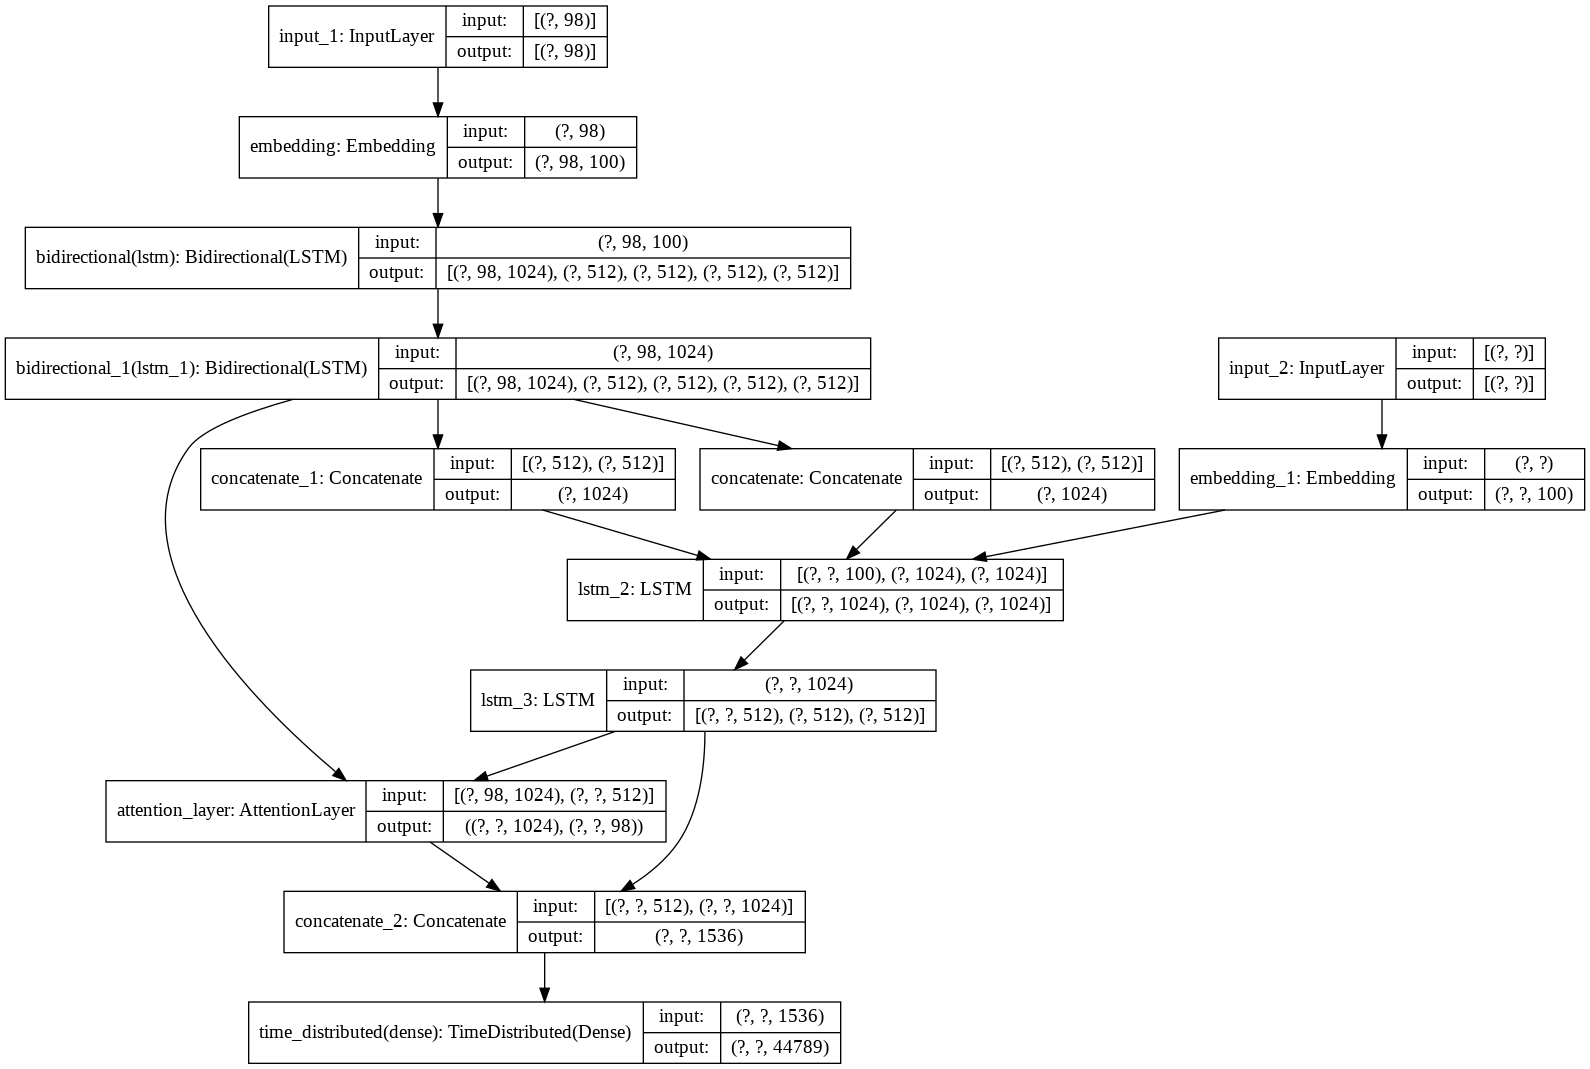

In [20]:
#encoder
encoder_input = Input(shape=(Tx, ))
  
encoder_embedding =  Embedding(vocab_size_X, 100, trainable=True)(encoder_input)

encoder_LSTM_1 = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True))
encoder_output, forward_h, forward_c, backward_h, backward_c = encoder_LSTM_1(encoder_embedding)

encoder_LSTM_2 = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True))
encoder_output, forward_h, forward_c, backward_h, backward_c = encoder_LSTM_2(encoder_output)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

# encoder_states = [hidden_state_3, cell_state_3] # uni-lstm

#decoder
decoder_input = Input(shape=(None, ))
  
decoder_embedding = Embedding(vocab_size_y, 100, trainable=True)(decoder_input)

decoder_LSTM_1 = LSTM(2*latent_dim, return_state=True, return_sequences=True)
decoder_output, _, _ = decoder_LSTM_1(decoder_embedding, initial_state=encoder_states)

decoder_LSTM_2 = LSTM(latent_dim, return_state=True, return_sequences=True)
decoder_output, _, _ = decoder_LSTM_2(decoder_output)

# attention
attention_layer = AttentionLayer()
attention_output, attention_states = attention_layer([encoder_output, decoder_output])
decoder_concat = Concatenate(axis=-1)([decoder_output, attention_output])

decoder_dense = TimeDistributed(Dense(vocab_size_y, activation='softmax'))
decoder_output = decoder_dense(decoder_concat)

model = Model([encoder_input, decoder_input], decoder_output)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(
    [X_train, y_train[:,:-1]], 
    y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:],
    epochs=10,
    batch_size=128, 
    validation_data=([X_test, y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:])
    )

Epoch 1/10
 34/731 [>.............................] - ETA: 17:17 - loss: 4.7573 - accuracy: 0.5523

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
model.save("headlines_model.h5")
files.download("headlines_model.h5")